<h1> Capstone Project - Finding Safe Neighbourhoods for Living for International Students in London
   

<h2> 1 Abstract

London is one of the most popular study destinations and has been ranked the 1st for Best Student Cities. It is also a popular destination for international students looking for higher education experiences. According to the Evening Standard, there are more than 120,000 international students in London in the year of 2018/19. Except for the expensive rent in London, many students are also concerned about the safety of the areas for living.

This project is going to review the boroughs in London based on total crimes numbers and types of each area, top venues in the borough will also be explored. In addition, the neighbourhoods will be clustered using k-means clustering. The results can be a reference for International students planning to find a safe and cosy home in London.

<h2> 2 Data Source

The data used in this study requires both the number of crimes committed during the past few years in each borough and the most popular venues within these areas. The safest borough and the top 10 venues in each area is analysed. In the section of finding the popular venues, foursquare data will be needed as location data.

The dataset used for crime is from Kaggle.com, containing 13 million of crimes classifed by the borough in which they occured, together with their category and time. The link to the data source is https://www.kaggle.com/jboysen/london-crime.

After the treatment of the crime data for all the boroughs in London, the dataset is complemented with additional information from the table on Wikipedia webpage: List of London boroughs (https://en.wikipedia.org/wiki/List_of_London_boroughs).

Once the safest borough is selected (Kingston upon Thames), the neighbourhoods and districts of this borough are found on the Wikipedia webpage: List of districts in the Royal Borough of Kingston upon Thames (https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames).

The top venues are explored in each neighbourhood using the data from Foursquare using the developer API (https://foursquare.com/developers/apps).

<h2>3 Data Processing
<h3>3.1 Crime Data
    

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

!conda install -c conda-forge geocoder --yes
import geocoder
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

import requests
import random

from IPython.display import Image
from IPython.core.display import HTML

from pandas.io.json import json_normalize
import folium

print ('Libraries import completed.')


Solving environment: done

## Package Plan ##

  environment location: /Users/senpei.peng/opt/anaconda3

  added / updated specs:
    - geocoder


The following packages will be UPDATED:

  conda                       pkgs/main::conda-4.8.3-py37_0 --> conda-forge::conda-4.8.3-py37hc8dfbb8_1

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2020.6.24-0 --> conda-forge::ca-certificates-2020.6.20-hecda079_0
  certifi               pkgs/main::certifi-2020.6.20-py37_0 --> conda-forge::certifi-2020.6.20-py37hc8dfbb8_0
  openssl              pkgs/main::openssl-1.1.1g-h1de35cc_0 --> conda-forge::openssl-1.1.1g-h0b31af3_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Libraries import completed.


In [3]:
# Foursquare Credentials
CLIENT_ID = 'ZCJD3ZOTFXDU4WYZ1OLMFWFENJWAEVO2TNXEKR1WFW1VE4QB'
CLIENT_SECRET = 'ZCKQUB1NESR3HX1ZIB0Y2KBECNSB5KN4GZCNUO33KLTAS1XS'
VERSION = '20200707'

LIMIT = 30

In [4]:
# Load data

df = pd.read_csv ('crime.csv')
df.head (10)

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6
5,E01001320,Ealing,Theft and Handling,Other Theft,0,2012,5
6,E01001342,Ealing,Violence Against the Person,Offensive Weapon,0,2010,7
7,E01002633,Hounslow,Robbery,Personal Property,0,2013,4
8,E01003496,Newham,Criminal Damage,Criminal Damage To Other Building,0,2013,9
9,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8


In [5]:
# Drop the results of years 2008 - 2015 to reduce the process demand
df.drop (df.index[df['year'] != 2016], inplace = True)

df = df.reset_index (drop = True)
df.shape

(1498956, 7)

In [6]:
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
3,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
4,E01002398,Hillingdon,Theft and Handling,Theft/Taking Of Motor Vehicle,0,2016,2


In [7]:
# Drop the entries where value is 0
df = df[df.value != 0]
df.shape

(392042, 7)

In [8]:
df.head ()

,lsoa_code,borough,major_category,minor_category,value,year,month
3,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
7,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
9,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
18,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
27,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [9]:
# Sum up the total number of crimes in each borough in 2016
df ['borough'].value_counts ()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

In [10]:
# Showing the number of crimes in each major category by borough
crime_sum = pd.pivot_table (df, values = ['value'], index = ['borough'], columns = ['major_category'],
                           aggfunc = np.sum, fill_value = 0)

crime_sum.reset_index (inplace = True)

# Showing the total number of each borough
crime_sum ['total']  = crime_sum.sum (axis = 1)

crime_sum.columns = crime_sum.columns.map (''. join)
crime_sum

,borough,valueBurglary,valueCriminal Damage,valueDrugs,valueOther Notifiable Offences,valueRobbery,valueTheft and Handling,valueViolence Against the Person,total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164
5,Camden,2652,1935,1493,490,899,14088,7626,29183
6,City of London,2,2,10,6,4,129,25,178
7,Croydon,2738,3219,1367,718,1139,9229,10302,28712
8,Ealing,2492,2562,1355,613,669,10040,9396,27127
9,Enfield,2541,2136,1063,492,807,8037,7409,22485


In [11]:
# Rename column names
crime_sum.columns = ['Borough', 'Burglary', 'Criminal Damage', 'Drug Crimes', 'Other Offences', 'Robbery', 
                    'Theft and Handling', 'Violence Against Person', 'Total']
crime_sum.head ()

,Borough,Burglary,Criminal Damage,Drug Crimes,Other Offences,Robbery,Theft and Handling,Violence Against Person,Total
0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,Barnet,3402,2183,906,499,464,9731,7499,24684
2,Bexley,1123,1673,646,294,209,4392,4503,12840
3,Brent,2631,2280,2096,536,919,9026,9205,26693
4,Bromley,2214,2202,728,417,369,7584,6650,20164


<h3> 3.2 Locating the Boroughs from Wikipedia Data

In [12]:
# Importing data from Wikipedia
wiki_url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
wiki_raw_data = requests.get (wiki_url).text

# Use beautiful soup to parse the xml code
soup = BeautifulSoup (wiki_raw_data, 'html')
soup.prettify ()

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   List of London boroughs - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"517c10f9-99e7-467d-8a63-3eecb60c0291","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":958873870,"wgRevisionId":958873870,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates","Geographic coord

In [13]:

# Convert the raw data into data frame
table = soup.find_all ('table', {'class': 'wikitable sortable'})
print (table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

In [37]:
borough_table = pd.read_html(str(table[0]), index_col=None, header=0) [0]
borough_table.head ()


,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [38]:
# Append the table of City of London

city_table = pd.read_html (str (table[1]), index_col = None, header = 0) [0]
city_table.columns = ['Borough','Inner','Status','Local authority','Political control','Headquarters',
                      'Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']
borough_table = borough_table.append (city_table, ignore_index = True)
borough_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


In [40]:
# Clean the text in the table

borough_table = borough_table.replace ('note 1', '', regex = True)\
.replace ('note 2', '', regex = True)\
.replace ('note 3', '', regex = True)\
.replace ('note 4', '', regex = True)\
.replace ('note 5', '', regex = True)

borough_table.head (10)


,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich [],[],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


In [43]:
# Clean the brackets
borough_table1 = borough_table.replace ('\[\]', '', regex = True)
borough_table1.head (10)

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich,,Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,264008,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


In [44]:
# Combine the data frames of the crimes and location data
ldn_crime = pd.merge (borough_table1, crime_sum, on = 'Borough')
ldn_crime.head ()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map,Burglary,Criminal Damage,Drug Crimes,Other Offences,Robbery,Theft and Handling,Violence Against Person,Total
0,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,3402,2183,906,499,464,9731,7499,24684
1,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,1123,1673,646,294,209,4392,4503,12840
2,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,2631,2280,2096,536,919,9026,9205,26693
3,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,2214,2202,728,417,369,7584,6650,20164
4,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11,2652,1935,1493,490,899,14088,7626,29183


In [46]:
# Drop the columns containing not relevant data
ldn_crime.drop (columns = ['Inner', 'Status', 'Political control', 'Headquarters'], axis = 1, inplace = True)
ldn_crime.head ()

,Borough,Local authority,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map,Burglary,Criminal Damage,Drug Crimes,Other Offences,Robbery,Theft and Handling,Violence Against Person,Total
0,Barnet,Barnet London Borough Council,33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31,3402,2183,906,499,464,9731,7499,24684
1,Bexley,Bexley London Borough Council,23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,1123,1673,646,294,209,4392,4503,12840
2,Brent,Brent London Borough Council,16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12,2631,2280,2096,536,919,9026,9205,26693
3,Bromley,Bromley London Borough Council,57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20,2214,2202,728,417,369,7584,6650,20164
4,Camden,Camden London Borough Council,8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11,2652,1935,1493,490,899,14088,7626,29183


<h2> 4 Exploratory Data Analysis
<h3> 4.1 Finding the Safest Borough

In [48]:
# Import libraries

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print ('Import Completed')

Import Completed


In [49]:
# Check the column names
ldn_crime.colunms = list (map (str, ldn_crime.columns))
all (isinstance (column, str) for column in ldn_crime.columns)

/Users/senpei.peng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


True

In [53]:
# Rearrage the table by boroughs 
ldn_crime.sort_values (['Total'], ascending = True, axis = 0, inplace = True)
ldn_crime.head (10)

,Borough,Local authority,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map,Burglary,Criminal Damage,Drug Crimes,Other Offences,Robbery,Theft and Handling,Violence Against Person,Total
29,City of London,Corporation of London;Inner Temple;Middle Temple,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1,2,2,10,6,4,129,25,178
16,Kingston upon Thames,Kingston upon Thames London Borough Council,14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,16,879,1054,743,189,121,3803,3194,9983
24,Sutton,Sutton London Borough Council,16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,18,1233,1316,461,253,165,3516,3714,10658
22,Richmond upon Thames,Richmond upon Thames London Borough Council,22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,15,1359,1148,320,217,106,4769,3155,11074
19,Merton,Merton London Borough Council,14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,17,1419,1418,466,249,283,4894,4026,12755
1,Bexley,Bexley London Borough Council,23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23,1123,1673,646,294,209,4392,4503,12840
10,Harrow,Harrow London Borough Council,19.49,243372,51°35′23″N 0°20′05″W﻿ / ﻿51.5898°N 0.3346°W,32,1994,1212,473,267,377,4537,4293,13153
11,Havering,Havering London Borough Council,43.35,242080,51°34′52″N 0°11′01″E﻿ / ﻿51.5812°N 0.1837°E,24,1826,1804,718,389,311,5919,5936,16903
21,Redbridge,Redbridge London Borough Council,21.78,288272,51°33′32″N 0°04′27″E﻿ / ﻿51.5590°N 0.0741°E,26,1997,1650,1017,381,599,7447,6411,19502
15,Kensington and Chelsea,Kensington and Chelsea London Borough Council,4.68,155594,51°30′07″N 0°11′41″W﻿ / ﻿51.5020°N 0.1947°W,3,1449,1051,1680,326,523,9855,4696,19580


In [54]:
# List of 10 safest boroughs in London
ldn_safe10 = ldn_crime.head (10)

<h4> The boroughs of least crimes committed in 2016 are:
    City of London, Kingston upon Thames, Sutton, Richmond upon Thames, Merton, Bexley, Harrow, Havering, Redbridge, Kensingtong and Chealsea

It is notable that the borough City of London has an area of only 1.12 square miles, not comparable to other boroughs with much larger areas. It is also an area where a lot of business located in but not living districts. In order to find the best areas for living, the analysis will exclude the results of City of London.

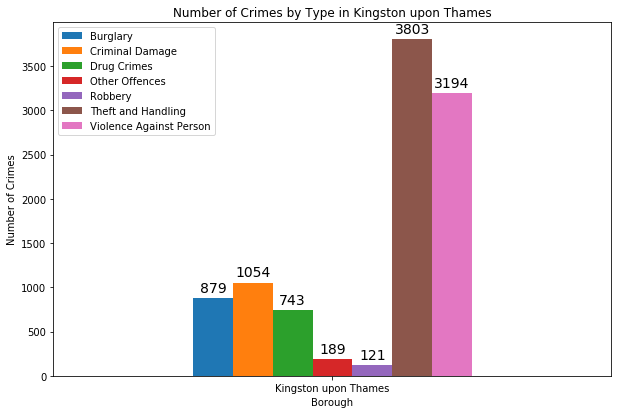

In [67]:
# Plot the crime types of borough with the second least crime 'Kingston upon Thames'
kingston =  ldn_safe10[ldn_safe10 ['Borough'] == 'Kingston upon Thames']

kingston_crime = kingston[['Borough','Burglary','Criminal Damage','Drug Crimes','Other Offences',
                 'Robbery','Theft and Handling','Violence Against Person']]

kingston_crime.set_index('Borough',inplace = True)

ax = kingston_crime.plot(kind='bar', figsize=(10, 6.5), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('Number of Crimes by Type in Kingston upon Thames') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

<h3> 4.2 Exploring the Neighbourhoods in the Safest Borough

In [72]:
# Create a Table of Kingston
Neighbourhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_kingston = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kingston_neigh = pd.DataFrame(data = df_kingston, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kingston_neigh

,Neighbourhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [74]:
# Find the Co-ordinates for each Neighbourhood in the Borough

Latitude = []
Longitude = []

for i in range(len(Neighbourhood)):
    address = '{},London,United Kingdom'.format(Neighbourhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)


[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [77]:
df_kingston = {'Neighbourhood': Neighbourhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kingston_neigh = pd.DataFrame(data = df_kingston, columns=['Neighbourhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kingston_neigh

,Neighbourhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


<h4> Visualise the Neighbourhoods in the Borough of Kinston upon Thames

In [85]:
# Address of the central neighbourhood
address = 'Kingston upon Thames, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

# Get the location data of Centre of Kington upon Thames
kingston_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, borough, neighbourhood in zip(kingston_neigh['Latitude'], kingston_neigh['Longitude'], kingston_neigh['Borough'], kingston_neigh['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = 'blue',
        fill_opacity = 0.7,
        parse_html = False).add_to(kingston_map)  
    
kingston_map

The geograpical coordinate of Berrylands, London are 51.4096275, -0.3062621.


<h4> Getting the popular venues in each neighbourhood

In [86]:
def getNearbyVenues (names, latitudes, longitudes, radius = 500):    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [88]:
# The venues in Kingston

kingston_venues = getNearbyVenues (names = kingston_neigh ['Neighbourhood'],
                                  latitudes = kingston_neigh ['Latitude'],
                                  longitudes = kingston_neigh ['Longitude'])

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [92]:
print (kingston_venues.head ())
print (kingston_venues.shape)

  Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0    Berrylands               51.393781                -0.284802   
1    Berrylands               51.393781                -0.284802   
2    Berrylands               51.393781                -0.284802   
3    Berrylands               51.393781                -0.284802   
4    Berrylands               51.393781                -0.284802   

                             Venue  Venue Latitude  Venue Longitude  \
0   Surbiton Racket & Fitness Club       51.392676        -0.290224   
1                   Alexandra Park       51.394230        -0.281206   
2                      K2 Bus Stop       51.392302        -0.281534   
3  Rob Taylor's Ultimate Gay Sauna       51.390022        -0.284894   
4                        Cafe Rosa       51.390175        -0.282490   

         Venue Category  
0  Gym / Fitness Center  
1                  Park  
2              Bus Stop  
3    Sauna / Steam Room  
4                  Café  
(171, 7)

In [93]:
kingston_venues.groupby ('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berrylands,5,5,5,5,5,5
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,5,5,5,5,5,5
New Malden,6,6,6,6,6,6


In [94]:
# One hot encoding
kingston_onehot = pd.get_dummies(kingston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kingston_onehot['Neighbourhood'] = kingston_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [kingston_onehot.columns[-1]] + list(kingston_onehot.columns[:-1])
kingston_onehot = kingston_onehot[fixed_columns]

kingston_onehot.head()

,Neighbourhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
# Get the occurence frequency of each type of venues

kingston_grouped = kingston_onehot.groupby ('Neighbourhood').mean ().reset_index ()
kingston_grouped

,Neighbourhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,Breakfast Spot,...,Shop & Service,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant
0,Berrylands,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.071429,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Coombe,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.00,0.00,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.00,0.00,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.00,0.00,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.066667,0.000000,0.033333,0.033333,0.000000,0.033333
6,Malden Rushett,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.00,0.00,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.04,0.04,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,...,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000


In [96]:
num_top_venues = 5

for hood in kingston_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = kingston_grouped[kingston_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2}) 
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center   0.2
1              Bus Stop   0.2
2    Sauna / Steam Room   0.2
3                  Park   0.2
4                  Café   0.2


----Canbury----
                  venue  freq
0                   Pub  0.29
1  Gym / Fitness Center  0.07
2        Shop & Service  0.07
3     Indian Restaurant  0.07
4                  Park  0.07


----Coombe----
              venue  freq
0          Tea Room   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3        Playground   0.0
4          Platform   0.0


----Hook----
               venue  freq
0  Indian Restaurant  0.25
1             Bakery  0.25
2  Fish & Chips Shop  0.25
3        Supermarket  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
              venue  freq
0     Grocery Store  0.25
1               Bar  0.25
2    Sandwich Place  0.25
3      Soccer Field  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames----
              venue  freq
0              C

<h4> List the venues in a data frame

In [97]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [100]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns = columns)
neighbourhoods_venues_sorted['Neighbourhood'] = kingston_grouped['Neighbourhood']

for ind in np.arange(kingston_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kingston_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Café,Bus Stop,Sauna / Steam Room,Fish & Chips Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food
1,Canbury,Pub,Gym / Fitness Center,Shop & Service,Park,Plaza,Café,Fish & Chips Shop,Hotel,Indian Restaurant,Spa
2,Coombe,Tea Room,Turkish Restaurant,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint
3,Hook,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Turkish Restaurant,French Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Turkish Restaurant,Food,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


<h4> Use k-means clustering to cluster the similar neighbourhoods

In [104]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kingston_grouped_clustering = kingston_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kingston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 1, 0, 0, 0, 2, 3, 0, 0], dtype=int32)

In [107]:
# add clustering labels
#neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kingston_merged = kingston_neigh

kingston_merged = kingston_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Neighbourhood')

kingston_merged.head() 

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Gym / Fitness Center,Park,Café,Bus Stop,Sauna / Steam Room,Fish & Chips Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0.0,Pub,Gym / Fitness Center,Shop & Service,Park,Plaza,Café,Fish & Chips Shop,Hotel,Indian Restaurant,Spa
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,1.0,Tea Room,Turkish Restaurant,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint
4,Hook,Kingston upon Thames,51.367898,-0.307145,0.0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Turkish Restaurant,French Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food


In [108]:
kingston_merged.dropna (inplace = True)
kingston_merged.head ()

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Gym / Fitness Center,Park,Café,Bus Stop,Sauna / Steam Room,Fish & Chips Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0.0,Pub,Gym / Fitness Center,Shop & Service,Park,Plaza,Café,Fish & Chips Shop,Hotel,Indian Restaurant,Spa
3,Coombe,Kingston upon Thames,51.419450,-0.265398,1.0,Tea Room,Turkish Restaurant,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint
4,Hook,Kingston upon Thames,51.367898,-0.307145,0.0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Turkish Restaurant,French Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0.0,Café,Pub,Burger Joint,Sushi Restaurant,Coffee Shop,Turkish Restaurant,Electronics Store,Gift Shop,German Restaurant,Furniture / Home Store


In [109]:
kingston_merged.info ()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighbourhood           14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [110]:
# Change type of cluster labels
kingston_merged ['Cluster Labels'] = kingston_merged ['Cluster Labels'].astype(int)

<h3> 4.3 Visualise the Clusters

In [113]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kingston_merged['Latitude'], kingston_merged['Longitude'], kingston_merged['Neighbourhood'], kingston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

<h4> Examine the Results

First Cluster

In [114]:
kingston_merged[kingston_merged['Cluster Labels'] == 0]

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0,Pub,Gym / Fitness Center,Shop & Service,Park,Plaza,Café,Fish & Chips Shop,Hotel,Indian Restaurant,Spa
4,Hook,Kingston upon Thames,51.367898,-0.307145,0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Turkish Restaurant,French Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Food
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0,Café,Pub,Burger Joint,Sushi Restaurant,Coffee Shop,Turkish Restaurant,Electronics Store,Gift Shop,German Restaurant,Furniture / Home Store
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,0,Grocery Store,Bar,Soccer Field,Sandwich Place,Turkish Restaurant,Food,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Indian Restaurant,Korean Restaurant,Gastropub,Sushi Restaurant,Supermarket,Bar,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Platform,Italian Restaurant,Indian Restaurant,Food,Pub,Rental Car Location,Coffee Shop,Pharmacy,Pizza Place,Hotel
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Pub,Coffee Shop,Turkish Restaurant,Café,Chinese Restaurant,Fast Food Restaurant,Fish & Chips Shop,Golf Course,Gym
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,0,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Train Station,French Restaurant,Hotel,Farmers Market,Deli / Bodega
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,0,Grocery Store,Pharmacy,Sandwich Place,Hotel,Café,Bus Stop,Restaurant,Discount Store,Indian Restaurant,Soccer Field


Second Cluster

In [115]:
kingston_merged[kingston_merged['Cluster Labels'] == 1]

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,1,Tea Room,Turkish Restaurant,French Restaurant,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Food,Fried Chicken Joint


Third Cluster

In [116]:
kingston_merged[kingston_merged['Cluster Labels'] == 2]

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,2,Grocery Store,Pub,Garden Center,Restaurant,Turkish Restaurant,Fish & Chips Shop,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant


Fourth Cluster

In [117]:
kingston_merged[kingston_merged['Cluster Labels'] == 3]

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Gym / Fitness Center,Park,Café,Bus Stop,Sauna / Steam Room,Fish & Chips Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Food
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Park,Restaurant,Bus Stop,Soccer Field,Food,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop


Fifth Cluster

In [119]:
kingston_merged[kingston_merged['Cluster Labels'] == 4]

,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,4,Train Station,Pub,Food,Deli / Bodega,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,French Restaurant


<h2> 5 Discussions

From the results of this project, it can been seen that the Kingston upon Thames is shown to be the safest borough in London for living. However, this result only takes in consideration of total crimes occured in that area without looking into the types of the crimes and the population of the area and therefore the results may not be strictly accurate. For example, the crimes of theft and burglary happens more frequently in the areas popular with tourists, such as Westminter, where many major tourist attractions are located, whereas the violence related crimes can be a major concern for international students when finding a home in a specific area.

Actually, the borough of Kingston upon Thames is not a very popular living areas for students as the location is somewhat remote to central London and only one university is located near this area. Most of the universities are located in central London, so further analysis of boroughs such as Camden, Kensington and Chelsea are desired.

<h2> 6 Conclusions

The exploratory analysis shows that the borough of Kingston upon Thames is the safest borough in London as least number of total crimes was occurred Around this area. Also for this borough, the most popular venues in each neighbourhood are listed for users to make decision from. Similar approach can be used to explore other boroughs and their neighbourhoods.